<a href="https://colab.research.google.com/github/lee021/2024-spark/blob/main/lee021/new_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [3]:
import findspark
import calendar
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, datediff, expr, lit, when, sum, udf, to_date, month, desc, asc, min, max, count_if
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from datetime import datetime
from pyspark.sql.window import Window


spark = SparkSession.builder\
  .master("local[*]")\
  .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

**데이터셋 준비**

In [4]:
weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
combined_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy.M.d'))

combined_df.show()

+----+-----------+------------+----------------------+---------------+------------+---------------+-----------------+-------------------+---------------+--------------+--------+
|date|   location|heat_wave_ox|highest_perceived_temp|max_temperature|average_temp|min_temperature|relative_humidity|heatwave_warning_ox|heatwave_impact|tropical_night|UV_level|
+----+-----------+------------+----------------------+---------------+------------+---------------+-----------------+-------------------+---------------+--------------+--------+
|NULL|북강릉(104)|           X|                  31.8|           31.4|        27.0|           22.8|             78.6|                  O|           경고|             O|    낮음|
|NULL|  동해(106)|           X|                  30.6|           30.0|        26.2|           22.8|             86.5|                  O|           주의|             O|    낮음|
|NULL|  서울(108)|           O|                  34.6|           34.2|        29.9|           25.5|             71.6|        

[박준영][3주차]

대한민국 행정구역별 평균 온도 분석

In [5]:
# # CSV 파일 읽기 (UTF-8 인코딩 지정)
# Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
# Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
# Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
# Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
# Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
# Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

# Df_List = [Df_04, Df_05, Df_06, Df_07, Df_08, Df_09]
# new_Df_List = []

# # 새 열 이름 정의
# new_columns = {
#     '일시': 'date',
#     '지점' : 'location',
#     '폭염여부(O/X)' : 'heat_wave_ox',
#     '최고체감온도(°C)' : 'highest_perceived_temp',
#     '최고기온(°C)': 'max_temperature',
#     '평균기온(°C)': 'average_temp',
#     '최저기온(°C)': 'min_temperature',
#     '평균상대습도(%)': 'relative_humidity',
#     '폭염특보(O/X)' : 'heatwave_warning_ox',
#     '열대야(O/X)' : 'tropical_night',
#     '자외선지수(단계)': 'UV_level',
#     '폭염영향예보(단계)' : 'heatwave_impact'
# }

# # 각 DataFrame 열 이름 변경
# for i, df in enumerate(Df_List):
#     for old_name, new_name in new_columns.items():
#         df = df.withColumnRenamed(old_name, new_name)
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List

# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09)
# # combined_df.show()

weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
combined_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy.M.d'))


# 문제 시작

regions = {

"서울특별시": ["108"],
"인천광역시": ["112"],
"부산광역시": ["159"],
"대구광역시": ["143"],
"대전광역시": ["133"],
"울산광역시": ["152"],
"광주광역시": ["156"], # "광주"를 경기도 광주가 아닌, 광주광역시로 분류.
"세종특별자치시": ["239"],
"경기도": [
    119, 202, 203, 551, 549, 434, 433, 437, 438, 441, 444, 445,
    505, 504, 516, 532, 540, 541, 545, 546, 548, 550, 555, 556,
    565, 569, 571, 572, 590, 598, 601, 602, 603, 604, 652, 98, 99
],
"강원도": [
    104, 106, 114, 115, 121, 211, 212, 216, 217, 526, 555, 556,
    606, 90, 876, 93, 517, 536, 670, 918, 95
],
"충청북도": [127, 131, 221, 226, 601, 602, 603, 604, 623],
"충청남도": [
    129, 235, 236, 238, 232, 612, 614, 615, 616, 618, 619, 627, 628,
    634, 636, 608
],
"전라북도": [140, 146, 702, 245, 247, 248, 254, 734, 737, 243, 701, 703, 244],
"전라남도": [
    165, 168, 169, 170, 172, 712, 713, 730, 731, 732, 706, 709,
    710, 741, 754, 768, 789, 259, 260, 261, 262, 699, 252
],
"경상북도": [
    135, 136, 137, 138, 271, 272, 273, 276, 277, 278, 279, 281,
    283, 284, 285, 288, 289, 294, 295, 801, 810, 812, 813, 815,
    822, 823, 825, 827, 130
],
"경상남도": [155, 162, 192, 253, 257, 264, 263, 268, 920, 919],
"제주특별자치도": ["184"]
}

# region 열 추가 (기본값 : UnKnown)
combined_df = combined_df.withColumn("region", lit("Unknown"))


# 지역별로 분류
for reg, codes in regions.items():
  for code in codes : # location 열 값이 codes(list)안에 포함되어 있는지 확인
    combined_df = combined_df.withColumn("region", when(col("location").contains(code),reg).otherwise(col("region")))


# 필요한 정보 추출 & double로 캐스팅
combined_df = combined_df.select("region", "average_temp")\
.withColumn("average_temp", combined_df["average_temp"].cast("double"))


# 최종 데이터 집계
combined_df = combined_df.groupBy("region").agg(
    avg("average_temp").alias("총평균기온")
).orderBy(desc("총평균기온")).withColumnRenamed("region", "도")

combined_df.show(500)





+--------------+------------------+
|            도|        총평균기온|
+--------------+------------------+
|제주특별자치도|23.403888888888893|
|    대구광역시| 22.66120218579234|
|    광주광역시|22.521857923497272|
|    서울특별시| 22.41147540983606|
|    부산광역시|22.162295081967212|
|    대전광역시|22.030601092896177|
|      경상남도|21.990525739320923|
|세종특별자치시|21.668852459016392|
|      전라남도|21.649831730769243|
|    울산광역시|21.590163934426233|
|      충청북도|  21.4557785888078|
|    인천광역시| 21.41475409836066|
|      전라북도|21.388210526315778|
|      경상북도|21.367729760332153|
|        경기도|   21.253480475382|
|      충청남도|21.235022252653216|
|        강원도|20.723999999999975|
+--------------+------------------+



[이성온][3주차]

폭염 & 자외선 기준으로 최고체감온도 집계하기

In [ ]:
# # CSV 파일 읽기 (UTF-8 인코딩 지정)
# Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
# Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
# Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
# Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
# Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
# Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

# Df_List = [Df_04, Df_05, Df_06, Df_07, Df_08, Df_09]
# new_Df_List = []

# # 새 열 이름 정의
# new_columns = {
#     '일시': 'date',
#     '지점' : 'location',
#     '폭염여부(O/X)' : 'heat_wave_ox',
#     '최고체감온도(°C)' : 'highest_perceived_temp',
#     '최고기온(°C)': 'max_temperature',
#     '평균기온(°C)': 'average_temp',
#     '최저기온(°C)': 'min_temperature',
#     '평균상대습도(%)': 'relative_humidity',
#     '폭염특보(O/X)' : 'heatwave_warning_ox',
#     '열대야(O/X)' : 'tropical_night',
#     '자외선지수(단계)': 'UV_level',
#     '폭염영향예보(단계)' : 'heatwave_impact'
# }

# # 각 DataFrame 열 이름 변경
# for i, df in enumerate(Df_List):
#     for old_name, new_name in new_columns.items():
#       # heatwave_impact열 제외, 모든 행의 값이 필수값이 되도록 필터링
#         # df = df.filter(all_not_null_condition)
#         df = df.withColumnRenamed(old_name, new_name)
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List


# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09)


# # 모든 값이 필수값이 되도록 필터링 (해당 열들이 모두 null이 아닐 때 true)
# # 최적화 가능?
# all_not_null_condition = (
#     col("일시").isNotNull() & col("지점").isNotNull() & col("폭염여부(O/X)").isNotNull() &
#     col("최고체감온도(°C)").isNotNull() & col("최고기온(°C)").isNotNull() & col("평균기온(°C)").isNotNull() &
#     col("최저기온(°C)").isNotNull() & col("평균상대습도(%)").isNotNull() & col("폭염특보(O/X)").isNotNull()
#     & col("열대야(O/X)").isNotNull() & col("자외선지수(단계)").isNotNull()
# )

weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
combined_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy.M.d'))


# 성온님 코드 참고 ----------

# weather_df.dropna 를 사용할 수도 있다.
# 각 컬럼 별 값이 없는 경우는 모두 필터링
combined_df = combined_df.filter(combined_df.heat_wave_ox.isNotNull())\
  .filter(combined_df.highest_perceived_temp.isNotNull())\
  .filter(combined_df.max_temperature.isNotNull())\
  .filter(combined_df.average_temp.isNotNull())\
  .filter(combined_df.min_temperature.isNotNull())\
  .filter(combined_df.relative_humidity.isNotNull())\
  .filter(combined_df.heatwave_warning_ox.isNotNull())\
  .filter(combined_df.heatwave_impact.isNotNull())\
  .filter(combined_df.tropical_night.isNotNull())\
  .filter(combined_df.UV_level.isNotNull())

# ----------





# 문제 시작

# 1. 폭염일 때와 아닐때의 최고체감온도 최소/평균/최대 값을 구하세요.

# highest_perceived_temp값을 double로 cast.
# result_df = combined_df.withColumn("highest_perceived_temp", combined_df["highest_perceived_temp"].cast("double"))

result_df = combined_df.groupBy("heat_wave_ox").agg(
    count('heat_wave_ox').alias('count(heatwave_ox)'), #####
    min('highest_perceived_temp').alias('min(highest_perceived_temp)'),
    avg('highest_perceived_temp').alias('avg(highest_perceived_temp)'),
    max('highest_perceived_temp').alias('max(highest_perceived_temp)')
)

result_df.show()


# 2. 폭염특보일 때와 아닐 때의 최고체감온도 최소/평균/최대 값을 구하세요.
# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09) # combined_df값이 바뀌었으므로 재정의
# highest_perceived_temp값을 double로 cast.
# result_df = combined_df.withColumn("highest_perceived_temp", combined_df["highest_perceived_temp"].cast("double"))

result_df = combined_df.groupBy("heatwave_warning_ox").agg(
    count('heatwave_warning_ox').alias('count(heatwave_warning_ox)'),
    min('highest_perceived_temp').alias('min(highest_perceived_temp)'),
    avg('highest_perceived_temp').alias('avg(highest_perceived_temp)'),
    max('highest_perceived_temp').alias('max(highest_perceived_temp)')
)

result_df.show()


# 3. 폭염영향예보 단계별 최고체감온도 최소/평균/최대 값을 구하세요.
# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09)
# highest_perceived_temp값을 double로 cast.
# result_df = combined_df.withColumn("highest_perceived_temp", combined_df["highest_perceived_temp"].cast("double"))

result_df = combined_df.groupBy("heatwave_impact").agg(
    count('heatwave_impact').alias('count(heatwave_impact)'),
    min('highest_perceived_temp').alias('min(highest_perceived_temp)'),
    avg('highest_perceived_temp').alias('avg(highest_perceived_temp)'),
    max('highest_perceived_temp').alias('max(highest_perceived_temp)')
)

result_df.show()


# 4. 자외선 지수 단계 별 온도의 최소, 최대, 평균값을 구합니다.
# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09)
# highest_perceived_temp값을 double로 cast.
# result_df = combined_df.withColumn("average_temp", combined_df["average_temp"].cast("double"))

result_df = combined_df.groupBy("UV_level").agg(
    count('UV_level').alias('count(UV_level)'),
    min('average_temp').alias('min(average_temp)'),
    max('average_temp').alias('max(average_temp)'),
    avg('average_temp').alias('avg(average_temp)')
).orderBy(asc("avg(average_temp)"))

result_df.show()



+------------+------------------+---------------------------+---------------------------+---------------------------+
|heat_wave_ox|count(heatwave_ox)|min(highest_perceived_temp)|avg(highest_perceived_temp)|max(highest_perceived_temp)|
+------------+------------------+---------------------------+---------------------------+---------------------------+
|           O|              3302|                       33.0|          34.15972138098129|                       37.8|
|           X|             24033|                        1.7|         25.538026879707093|                       32.9|
+------------+------------------+---------------------------+---------------------------+---------------------------+

+-------------------+--------------------------+---------------------------+---------------------------+---------------------------+
|heatwave_warning_ox|count(heatwave_warning_ox)|min(highest_perceived_temp)|avg(highest_perceived_temp)|max(highest_perceived_temp)|
+-------------------+----

**[고승빈][3주차]**

매 달 마다 폭염특보가 가장 많이 발효된 지역 찾기

In [ ]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window


# # CSV 파일 읽기 (UTF-8 인코딩 지정)
# Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
# Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
# Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
# Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
# Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
# Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

# Df_List = [Df_06, Df_07, Df_08, Df_09]
# new_Df_List = []

# # 새 열 이름 정의
# new_columns = {
#     '일시': 'date',
#     '지점' : 'location',
#     '폭염여부(O/X)' : 'heat_wave',
#     '최고체감온도(°C)' : 'max_wind_chill_temperature',
#     '최고기온(°C)': 'max_temperature',
#     '평균기온(°C)': 'average_temperature',
#     '최저기온(°C)': 'min_temperature',
#     '평균상대습도(%)': 'relative_humidity',
#     '폭염특보(O/X)' : 'heat_wave_alert',
#     '열대야' : 'tropical_night',
#     '자외선지수(단계)': 'UV'
# }

# # 각 DataFrame에 열 이름 변경 및 정렬 적용
# for i, df in enumerate(Df_List):
#     for old_name, new_name in new_columns.items():
#         df = df.withColumnRenamed(old_name, new_name)
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_06, Df_07, Df_08, Df_09 = Df_List


# combined_df = Df_06.union(Df_07).union(Df_08).union(Df_09)

weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
combined_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy-MM-dd'))


# 문제 시작

# for i, df in enumerate(Df_List):
#     df = df.withColumn('month', month(col('date'))) # timestamp 데이터에서 월 추출 : 숫자로 표시
#     df = df.groupBy('location', 'month').agg( # location, month를 기준으로 집계
#         count(when(col('heat_wave_alert') == 'O', True)).alias('heatwave_count') # 특염 특보 발생 수 카운트
#     )
#     df = df.select('month', 'heatwave_count', 'location') # 열 재배치
#     df = df.orderBy(desc('heatwave_count'), asc('location')) # 정렬
#     df = df.limit(1) # 첫 행 제외 다 삭제 => 월 별로 최대값 추출
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 언패킹
# Df_06, Df_07, Df_08, Df_09 = Df_List


# combined_df = Df_06.union(Df_07).union(Df_08).union(Df_09)
# combined_df.show()


# 성온님 코드 기반 수정



windowSpec = Window.partitionBy('month').orderBy(col('heatwave_warning_count').desc())
# Window : 데이터의 특정 그룹에 대해 행 간의 관계를 기반으로 계산을 수행
# partitionBy : 그룹화할 열 지정
# orderBy : 정렬할 열 지정

p3_weather_df = combined_df.withColumn('month', month('date'))\
  .groupby('month', 'location')\
  .agg(count_if(col('heatwave_warning_ox') == 'O').alias('heatwave_warning_count'))\
  .filter(col('heatwave_warning_count') > 0)\
  .orderBy('location')\
  .withColumn('rank', row_number().over(windowSpec))\
  .filter(col('rank') == 1)\
  .show()





+-----+----------+----------------------+----+
|month|  location|heatwave_warning_count|rank|
+-----+----------+----------------------+----+
|    6|북춘천(93)|                     6|   1|
|    7| 경산(827)|                    20|   1|
|    8| 거제(294)|                    26|   1|
|    9| 구례(709)|                     6|   1|
+-----+----------+----------------------+----+



**[박수지][3주차] 과제**

**서울의 기온과 폭염특보의 관계**

In [ ]:
# # CSV 파일 읽기 (UTF-8 인코딩 지정)
# Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
# Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
# Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
# Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
# Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
# Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

# Df_List = [Df_04, Df_05, Df_06, Df_07, Df_08, Df_09]
# new_Df_List = []

# # 새 열 이름 정의
# new_columns = {
#     '일시': 'date',
#     '지점' : 'location',
#     '폭염여부(O/X)' : 'heat_wave',
#     '최고체감온도(°C)' : 'max_wind_chill_temperature',
#     '최고기온(°C)': 'max_temperature',
#     '평균기온(°C)': 'average_temperature',
#     '최저기온(°C)': 'min_temperature',
#     '평균상대습도(%)': 'relative_humidity',
#     '폭염특보(O/X)' : 'heat_wave_alert',
#     '열대야' : 'tropical_night',
#     '자외선지수(단계)': 'UV'
# }

# # 각 DataFrame 열 이름 변경
# for i, df in enumerate(Df_List):
#     for old_name, new_name in new_columns.items():
#         df = df.withColumnRenamed(old_name, new_name)
#     df = df.orderBy('date') # 정렬
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List

# combined_df = Df_04.union(Df_05).union(Df_06).union(Df_07).union(Df_08).union(Df_09)

weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
p2_weather_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy-MM-dd'))

# 문제 시작

# solve problem
from pyspark.sql.functions import date_format

# p2_weather_df = combined_df.withColumn('date', to_date('date', 'yyyy.M.d')) # to_date


p2_weather_df = combined_df.filter('location == "서울(108)"')\
  .withColumn('month', date_format(col('date'), 'MMMM')) # date_format

p2_weather_df\
  .groupBy('month')\
  .agg(
      avg('max_temperature').alias('avg_high_temp'),
      avg('average_temp').alias('avg_temp'),
      avg('min_temperature').alias('avg_low_temp'),
      count_if(col('heatwave_warning_ox') == "O").alias('so_hot')
  )\
  .orderBy('so_hot', ascending=False)\
  .show()


# # UDF 정의
# def get_month_name(date_str):
#     # datetime 모듈 제공 함수 strptime : 문자열 => 'datetime'객체로 변환
#     # Question. 이미 형태는 연-월-일 아닌가?
#     date_obj = datetime.strptime(date_str, '%Y-%m-%d')
#     # calendar 모듈 제공 속성 month_name : 1~12월 이름 포함 튜플 => 튜플의 인덱스를 활용해 해당 월의 이름 추출 가능
#     return calendar.month_name[date_obj.month]

# # UDF 등록
# month_name_udf = udf(get_month_name, StringType()) # 반환값 : String

# # UDF 적용 및 월 이름 열 추가
# for i, df in enumerate(Df_List):
#     df = df.withColumn('month', month_name_udf(col('date')))
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 언패킹
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List

# for df in Df_List:
#   new_df = df.filter(col('location')=='서울(108)') # 지역 : 서울로 필터링
#   count_heat_wave_alert = new_df.filter(col('heat_wave_alert')=='O').count() # 서울의 폭염특보 발생 수 카운트 => filtering한 행의 갯수

#   new_df = new_df.groupBy('location', 'month').agg(
#       avg('max_temperature').alias('avgHightmp'),
#       avg('average_temperature').alias('avgtmp'),
#       avg('min_temperature').alias('avgLowtmp')
#   )
#   # new_df = new_df.join(df, on='location') # agg과정 중 month가 삭제돼어, month를 얻기위해 join한 것. Q. 더 최적화 되려나? => groupBy 에 추가
#   new_df = new_df.withColumn('soHot', lit(count_heat_wave_alert)) # 폭염특보 수 추가
#   new_df = new_df.select('month', 'avgHightmp', 'avgtmp', 'avgLowtmp', 'soHot').dropDuplicates()
#   new_Df_List.append(new_df)


# # 언패킹
# new_Df_04, new_Df_05, new_Df_06, new_Df_07, new_Df_08, new_Df_09 = new_Df_List

# # DataFrame 합치기
# combined_df = new_Df_04.union(new_Df_05).union(new_Df_06)\
# .union(new_Df_07).union(new_Df_08).union(new_Df_09)

# # 결과 출력
# combined_df.orderBy(desc('soHot'), desc('avgtmp')).show()






+---------+------------------+------------------+------------------+------+
|    month|     avg_high_temp|          avg_temp|      avg_low_temp|so_hot|
+---------+------------------+------------------+------------------+------+
|   August| 30.76451612903226|27.187096774193545|24.309677419354834|    19|
|     July|30.193548387096772| 26.70645161290323|23.851612903225806|    14|
|     June| 27.85333333333334|23.383333333333333| 19.74666666666667|     3|
|September|27.616666666666674|23.663333333333338|20.233333333333338|     2|
|      May|25.041935483870965| 19.52258064516129|14.606451612903227|     0|
|    April| 18.95333333333333|13.799999999999999| 8.806666666666665|     0|
+---------+------------------+------------------+------------------+------+



**분석과제 [이태용]**

**자외선지수와 온도, 습도와의 상관관계 분석**

문제설명:

1. 일별로 평균최고온도, 평균상대습도, 평균자외선 지수를 구한다. [바로 아래 예시 참고]



> ※ 자외선지수는 기상정보에 따라 다음과 같이 수치화한다.

> "낮음": 1.5,  "보통": 4.5,  "높음": 7,     "매우높음": 9.5, "위험": 13




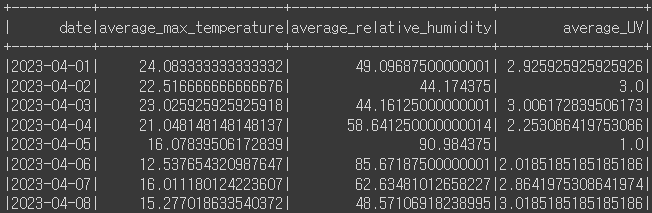

2. average_max_temperature의 평균 값보다 높은 행들 필터링, 낮은 행들 각각 필터링

예시 :
average_max_temperature의 값이 average_max_temperature의 평균 값보다 높은 행들만을 필터링한 결과입니다.

average_max_temperature의 평균 값 : 26.68xxxx..
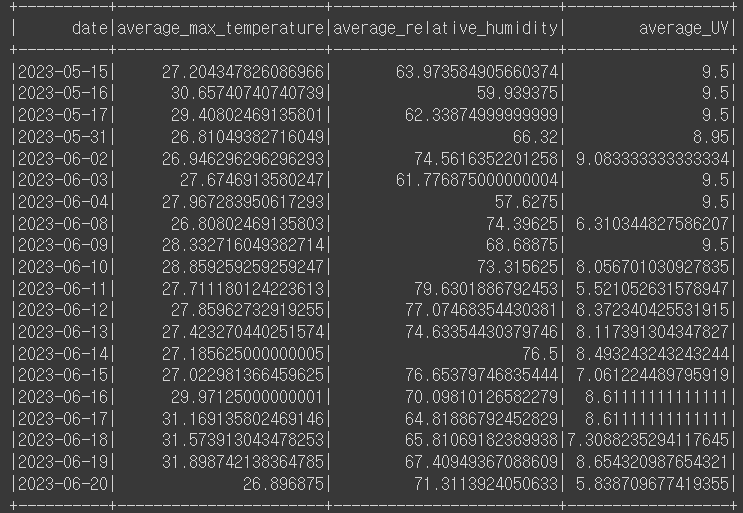

3. 필터링된 두 dataframe의 avg(average_UV) 값을 추출하여 출력.

4. average_relative_humidity의 평균 값보다 높은 행들 필터링, 낮은 행들 필터링

5. 필터링된 두 dataframe의 avg(average_UV) 값을 추출하여 출력.


출력 결과 예시 :

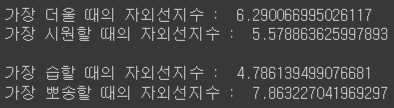

In [7]:
# # CSV 파일 읽기 (UTF-8 인코딩 지정)
# Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
# Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
# Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
# Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
# Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
# Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

# Df_List = [Df_04, Df_05, Df_06, Df_07, Df_08, Df_09]

# # 새 열 이름 정의
# new_columns = {
#     '일시': 'date',
#     '지점' : 'location',
#     '폭염여부(O/X)' : 'heat_wave',
#     '최고체감온도(°C)' : 'max_wind_chill_temperature',
#     '최고기온(°C)': 'max_temperature',
#     '평균기온(°C)': 'average_temperature',
#     '최저기온(°C)': 'min_temperature',
#     '평균상대습도(%)': 'relative_humidity',
#     '폭염특보(O/X)' : 'heat_wave_alert',
#     '열대야' : 'tropical_night',
#     '자외선지수(단계)': 'UV'
# }

# # 각 DataFrame 열 이름 변경
# for i, df in enumerate(Df_List):
#     for old_name, new_name in new_columns.items():
#         df = df.withColumnRenamed(old_name, new_name)
#     df = df.orderBy('date') # 정렬
#     Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List





# 문제 시작 -----------------------

weather_lables = [
    ('date', StringType()),
    ('location', StringType()),
    ('heat_wave_ox', StringType()),
    ('highest_perceived_temp', DoubleType()),
    ('max_temperature', DoubleType()),
    ('average_temp', DoubleType()),
    ('min_temperature', DoubleType()),
    ('relative_humidity', DoubleType()),
    ('heatwave_warning_ox', StringType()),
    ('heatwave_impact', StringType()),
    ('tropical_night', StringType()),
    ('UV_level', StringType()),
]

weather_schema = StructType([StructField(x[0], x[1], True) for x in weather_lables])
p1_weather_df = spark.read.csv('weather_data/', header=True, sep=",", schema=weather_schema, encoding='CP949').withColumn('date', to_date('date', 'yyyy-MM-dd'))

# define udf & add uv column
uv_level_to_number_dic = {
    '낮음': 1.5,
    '보통': 4.5,
    '높음': 7.0,
    '매우높음': 9.5,
    '위험': 13.0,
}
uv_level_to_number_udf = udf(lambda x: uv_level_to_number_dic.get(x, 0.0), DoubleType())
p1_weather_df = p1_weather_df.withColumn('uv', uv_level_to_number_udf(p1_weather_df.UV_level))

# problem 1-1
p1_weather_avg_df = p1_weather_df.groupBy('date').agg(
    avg('max_temperature').alias('average_max_temperature'),
    avg('relative_humidity').alias('average_relative_humidity'),
    avg('uv').alias('average_uv')
).orderBy('date')
p1_weather_avg_df.show(10)



# new_Df_List = []

# ## 평균최대기온, 평균상대습도 추출
# # '일시' 열을 기준으로 agg
# for df in p1_weather_df:
#   new_df = df.groupBy('date').agg(
#       avg('max_temperature').alias('average_max_temperature'),
#       avg('relative_humidity').alias('average_relative_humidity')
#   )
#   new_Df_List.append(new_df) # new_Df_List 최신화

# # 언패킹
# new_Df_04, new_Df_05, new_Df_06, new_Df_07, new_Df_08, new_Df_09 = new_Df_List
# print("new_Df의 예시")
# new_Df_04.show()






# ## 평균 자외선지수 추출

# # 자외선지수 수치화
# # UDF 정의
# def uv_index_to_numeric(uv_index):
#     mapping = {
#         "낮음": 1.5,
#         "보통": 4.5,
#         "높음": 7,
#         "매우높음": 9.5,
#         "위험" : 13.0
#     }
#     return mapping.get(uv_index, 0) # key값 받아옴. (기본값 : 0)

# # UDF 등록
# uv_index_to_numeric_udf = udf(uv_index_to_numeric, DoubleType())

# # UDF 적용
# for i, df in enumerate(Df_List):
#   Df_List[i] = df.withColumn("UV", uv_index_to_numeric_udf(col("UV")))
#   Df_List[i] = Df_List[i].groupBy('date').agg(
#     avg('UV').alias('average_UV')
# ).orderBy('date')

# # 변경된 Df_List 각각 변수에 저장 (언패킹)
# Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List
# print("Df의 예시")
# Df_04.show()







# # 최종 join
# merged_List = []

# for i, df in enumerate(Df_List):
#   merged_df = new_Df_List[i].join(df, 'date')
#   merged_List.append(merged_df)

# # 언패킹
# df_merged_04, df_merged_05, df_merged_06, df_merged_07, df_merged_08, df_merged_09 = merged_List



# # DataFrame 합치기
# combined_df = df_merged_04.union(df_merged_05).union(df_merged_06)\
# .union(df_merged_07).union(df_merged_08).union(df_merged_09)

# combined_df.show()



+----------+-----------------------+-------------------------+-----------------+
|      date|average_max_temperature|average_relative_humidity|       average_uv|
+----------+-----------------------+-------------------------+-----------------+
|2023-04-01|     24.083333333333332|        49.09687500000001|6.814814814814815|
|2023-04-02|     22.516666666666676|                44.174375|              7.0|
|2023-04-03|     23.025925925925918|        44.16125000000001|7.015432098765432|
|2023-04-04|     21.048148148148137|       58.641250000000014|5.132716049382716|
|2023-04-05|      16.07839506172839|                90.984375|              1.5|
|2023-04-06|     12.537654320987647|        85.67187500000001|4.546296296296297|
|2023-04-07|     16.011180124223607|        62.63481012658227|6.660493827160494|
|2023-04-08|     15.277018633540372|        48.57106918238995|7.046296296296297|
|2023-04-09|     18.766459627329205|        51.61139240506329|7.046296296296297|
|2023-04-10|     20.48074534

In [10]:
# average_max_temperature의 평균 값 계산
# collect()[0][0] 을 통해 값을 추출할 수 있음.
avg_max_temp = p1_weather_avg_df.select(avg('average_max_temperature')).collect()[0][0]

# 평균보다 높은 행 필터링
# 'average_max_temperature' 열 값 중 avg_max_temp 값 보다 큰 값들을 필터링
high_temp = p1_weather_avg_df.filter(p1_weather_avg_df['average_max_temperature'] > avg_max_temp)

# 평균보다 낮은 행 필터링
low_temp = p1_weather_avg_df.filter(p1_weather_avg_df['average_max_temperature'] <= avg_max_temp)

# 결과 출력 (선택)
high_temp.show()
low_temp.show()

high_temp_UV = high_temp.select(avg('average_UV')).collect()[0][0]
# 왜 8.95?
low_temp_UV = low_temp.select(avg('average_UV')).collect()[0][0]

# 최종 결과 도출
print("가장 더울 때의 자외선지수 : ",high_temp_UV)
print("가장 시원할 때의 자외선지수 : ",low_temp_UV)




# average_max_temperature의 평균 값 계산
avg_relative_humidity = p1_weather_avg_df.select(avg('average_relative_humidity')).collect()[0][0]

# 평균보다 높은 행 필터링
high_hum = p1_weather_avg_df.filter(p1_weather_avg_df['average_relative_humidity'] > avg_relative_humidity)

# 평균보다 낮은 행 필터링
low_hum = p1_weather_avg_df.filter(p1_weather_avg_df['average_relative_humidity'] <= avg_relative_humidity)

# 결과 출력 (선택)
# high_hum.show(100)
# low_hum.show(100)

high_hum_UV = high_hum.select(avg('average_UV')).collect()[0][0]
low_hum_UV = low_hum.select(avg('average_UV')).collect()[0][0]

# 최종 결과 도출
print("\n가장 습할 때의 자외선지수 : ",high_hum_UV)
print("가장 뽀송할 때의 자외선지수 : ",low_hum_UV)




+----------+-----------------------+-------------------------+-----------------+
|      date|average_max_temperature|average_relative_humidity|       average_uv|
+----------+-----------------------+-------------------------+-----------------+
|2023-05-15|     27.204347826086966|       63.973584905660374|9.484567901234568|
|2023-05-16|      30.65740740740739|                59.939375|              9.5|
|2023-05-17|      29.40802469135801|        62.33874999999999|9.438271604938272|
|2023-05-31|      26.81049382716049|                    66.32|8.203703703703704|
|2023-06-02|     26.946296296296293|         74.5616352201258|8.697530864197532|
|2023-06-03|       27.6746913580247|       61.776875000000004|              9.5|
|2023-06-04|     27.967283950617293|                  57.6275|9.268518518518519|
|2023-06-08|      26.80802469135803|                 74.39625|6.753086419753086|
|2023-06-09|     28.332716049382714|                 68.68875| 9.42283950617284|
|2023-06-10|     28.85925925